# Starting Point

In [1]:
# Install necessary libraries 
!pip install transformers
!pip install torch torchvision
!pip install nltk
!pip install rouge-score
!pip install wer
!pip install gtts


  Preparing metadata (setup.py) ... - done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=9012c9bfae888ba9c32e695a91b7acd70ae074f6674fe2a91616f24b14f101b3
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.6/216.6 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 4.1 MB/s eta 0:00:00


In [2]:
# General imports
import os
import random
import pickle
import warnings
import numpy as np
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# TensorFlow and Keras related imports
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, Bidirectional, BatchNormalization, RepeatVector, Dot, Activation, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import VGG16, MobileNetV3Large
from tensorflow.keras.layers import Add
import matplotlib.image as mpimg
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Additional utilities
from tensorflow.keras.utils import to_categorical, plot_model
from nltk.translate.bleu_score import corpus_bleu

# Transformers for BLIP model
from transformers import BlipProcessor, BlipForConditionalGeneration

# Rouge Score for evaluating model performance 
from rouge_score import rouge_scorer

# Handle warnings
warnings.filterwarnings("ignore", category=FutureWarning)


import nltk
nltk.download('punkt')
nltk.download('stopwords')

from gtts import gTTS
from IPython.display import Audio, display

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# requirements

In [3]:
import pkg_resources
import types
def get_imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
        
            name = val.__name__.split(".")[0]

        elif isinstance(val, type):
            name = val.__module__.split(".")[0]

        
        if name == "PIL":
            name = "Pillow"
        elif name == "sklearn":
            name = "scikit-learn"

        yield name
imports = list(set(get_imports()))

requirements = []
for m in pkg_resources.working_set:
    if m.project_name in imports and m.project_name!="pip":
        requirements.append((m.project_name, m.version))

for r in requirements:
    print("{}=={}".format(*r))


keras==3.3.3
matplotlib==3.7.5
nltk==3.2.4
numpy==1.26.4
tensorflow==2.16.1
tqdm==4.66.4
transformers==4.45.1


/tmp/ipykernel_23/2833026152.py:1: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import pkg_resources


# Directories

In [4]:
BASE_DIR = '/kaggle/input/flickr8k'
WORKING_DIR = '/kaggle/working'


# Load and Process Captions

In [5]:
with open(os.path.join(BASE_DIR, 'captions.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()

mapping = {}
for line in tqdm(captions_doc.split('\n')):
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    image_id = image_id.split('.')[0]
    caption = " ".join(caption)
    if image_id not in mapping:
        mapping[image_id] = []
    mapping[image_id].append(caption)


100%|██████████| 40456/40456 [00:00<00:00, 691152.14it/s]


**Demo of og Caption**

In [6]:
with open(os.path.join(BASE_DIR, 'captions.txt'), 'r') as f:
    next(f)  
    for i, line in enumerate(f):
        print(line)  
        if i == 1:  
            break


1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .

1000268201_693b08cb0e.jpg,A girl going into a wooden building .



In [7]:
example_keys = list(mapping.keys())[:2]  
for key in example_keys:
    print(f"Image ID: {key}")
    for caption in mapping[key]:
        print(f"Caption: {caption}")
    print("-" * 50)  


Image ID: 1000268201_693b08cb0e
Caption: A child in a pink dress is climbing up a set of stairs in an entry way .
Caption: A girl going into a wooden building .
Caption: A little girl climbing into a wooden playhouse .
Caption: A little girl climbing the stairs to her playhouse .
Caption: A little girl in a pink dress going into a wooden cabin .
--------------------------------------------------
Image ID: 1001773457_577c3a7d70
Caption: A black dog and a spotted dog are fighting
Caption: A black dog and a tri-colored dog playing with each other on the road .
Caption: A black dog and a white dog with brown spots are staring at each other in the street .
Caption: Two dogs of different breeds looking at each other on the road .
Caption: Two dogs on pavement moving toward each other .
--------------------------------------------------


# Clean the Captions

In [8]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            caption = captions[i]
            caption = caption.lower()
            caption = caption.replace('[^A-Za-z]', '')
            caption = caption.replace('\s+', ' ')
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

clean(mapping)


In [9]:
example_keys = list(mapping.keys())[:2]  
for key in example_keys:
    print(f"Image ID: {key}")
    for caption in mapping[key]:
        print(f"Cleaned Caption: {caption}")
    print("-" * 50)  


Image ID: 1000268201_693b08cb0e
Cleaned Caption: startseq child in pink dress is climbing up set of stairs in an entry way endseq
Cleaned Caption: startseq girl going into wooden building endseq
Cleaned Caption: startseq little girl climbing into wooden playhouse endseq
Cleaned Caption: startseq little girl climbing the stairs to her playhouse endseq
Cleaned Caption: startseq little girl in pink dress going into wooden cabin endseq
--------------------------------------------------
Image ID: 1001773457_577c3a7d70
Cleaned Caption: startseq black dog and spotted dog are fighting endseq
Cleaned Caption: startseq black dog and tri-colored dog playing with each other on the road endseq
Cleaned Caption: startseq black dog and white dog with brown spots are staring at each other in the street endseq
Cleaned Caption: startseq two dogs of different breeds looking at each other on the road endseq
Cleaned Caption: startseq two dogs on pavement moving toward each other endseq
---------------------

# Tokenize the Captions

In [10]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1


In [11]:
print("Before Tokenization:")
for i in range(2):
    print(all_captions[i]) 

print("\nAfter Tokenization:")
for i in range(2):
    sequence = tokenizer.texts_to_sequences([all_captions[i]])[0]  
    print(sequence)  


Before Tokenization:
startseq child in pink dress is climbing up set of stairs in an entry way endseq
startseq girl going into wooden building endseq

After Tokenization:
[1, 42, 3, 90, 172, 6, 119, 50, 393, 11, 394, 3, 27, 5146, 670, 2]
[1, 18, 316, 64, 196, 117, 2]


In [12]:
pickle.dump(tokenizer, open(os.path.join(WORKING_DIR, 'tokenizer.pkl'), 'wb'))


# Split Data into Training and Testing Sets

In [13]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

print("Number of training samples:", len(train))
print("Number of testing samples:", len(test))


Number of training samples: 7281
Number of testing samples: 810


# Define Maximum Caption Length

In [14]:
max_length = max(len(caption.split()) for caption in all_captions)
print("Maximum Caption Length:",(max_length))

Maximum Caption Length: 35


# VGG16

In [15]:
model = VGG16()
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
print(model.summary())


553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 134,260,544 (512.16 MB)

 Non-trainable params: 0 (0.00 B)

None


# Extract Image Features Using VGG16

In [16]:
from tensorflow.keras.applications.vgg16 import preprocess_input

features = {}
directory = os.path.join(BASE_DIR, 'Images')

for img_name in tqdm(os.listdir(directory)):
    img_path = directory + '/' + img_name
    image = load_img(img_path, target_size=(224, 224))
    image = img_to_array(image)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    image = preprocess_input(image)
    feature = model.predict(image, verbose=0)
    image_id = img_name.split('.')[0]
    features[image_id] = feature

  0%|          | 0/8091 [00:00<?, ?it/s]WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
I0000 00:00:1732708994.437768     101 service.cc:145] XLA service 0x7e31ec002e30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732708994.437812     101 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1732708994.437816     101 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1732708997.075618     101 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
100%|██████████| 8091/8091 [10:09<00:00, 13.27it/s]


**Image In The Dataset**

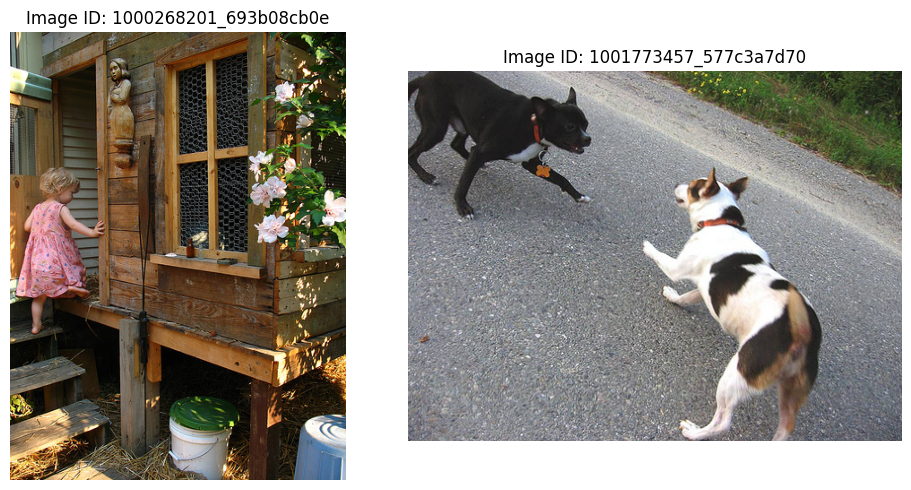

In [17]:

IMAGES_DIR = os.path.join(BASE_DIR, 'Images')

image_files = list(mapping.keys())[:2]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))  

for i, image_id in enumerate(image_files):
    image_path = os.path.join(IMAGES_DIR, image_id + '.jpg')  
    if os.path.exists(image_path): 
        img = mpimg.imread(image_path)
        axes[i].imshow(img) 
        axes[i].set_title(f"Image ID: {image_id}")
        axes[i].axis('off')  
    else:
        print(f"Image {image_id}.jpg not found in the dataset.")

plt.tight_layout() 
plt.show()


**Image With Captions**

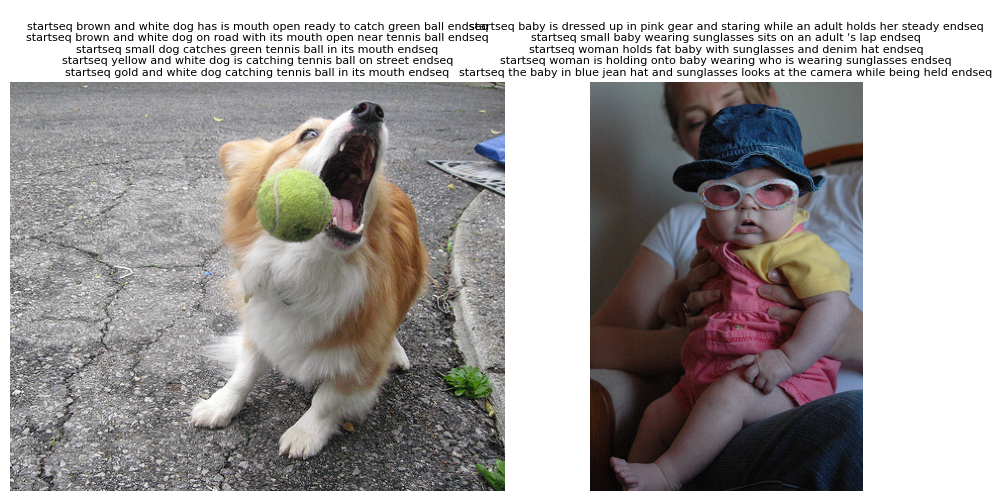

In [18]:

def display_random_images(directory, mapping, num_images=2):
   
    image_ids = random.sample(list(mapping.keys()), num_images)
    fig, axes = plt.subplots(1, num_images, figsize=(10, 5))
    
    for i, image_id in enumerate(image_ids):
        img_path = os.path.join(directory, image_id + '.jpg') 
        
        if os.path.exists(img_path):
            img = mpimg.imread(img_path)
            
            axes[i].imshow(img)
            axes[i].axis('off')  
            
            captions = mapping[image_id]
            caption_text = "\n".join(captions)
            axes[i].set_title(caption_text, fontsize=8, wrap=True)
        else:
            axes[i].axis('off')  
            axes[i].set_title(f"Image {image_id}.jpg not found.", fontsize=12)
    
    plt.tight_layout()
    plt.show()


image_directory = os.path.join(BASE_DIR, 'Images')
display_random_images(image_directory, mapping)


**Image after Feature Extracting**

In [19]:
for i, (key, value) in enumerate(features.items()):
    if i < 2:
        print(f"Image ID: {key}")
        print(f"Feature shape for {key}: {value.shape}")
        print(f"Feature for {key}: {value}")
    else:
        break


Image ID: 3226254560_2f8ac147ea
Feature shape for 3226254560_2f8ac147ea: (1, 4096)
Feature for 3226254560_2f8ac147ea: [[0.        1.6273935 0.        ... 0.        1.5637901 0.       ]]
Image ID: 214543992_ce6c0d9f9b
Feature shape for 214543992_ce6c0d9f9b: (1, 4096)
Feature for 214543992_ce6c0d9f9b: [[0.        3.4764287 7.3570986 ... 0.        0.        0.       ]]


In [20]:
pickle.dump(features, open(os.path.join(WORKING_DIR, 'features.pkl'), 'wb'))

# Data Generator for Model Training(VGG16)

In [21]:
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            for caption in captions:
                seq = tokenizer.texts_to_sequences([caption])[0]
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_length, padding='post')[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield {"image": X1, "text": X2}, y
                X1, X2, y = list(), list(), list()
                n = 0


# Create the Model with VGG16

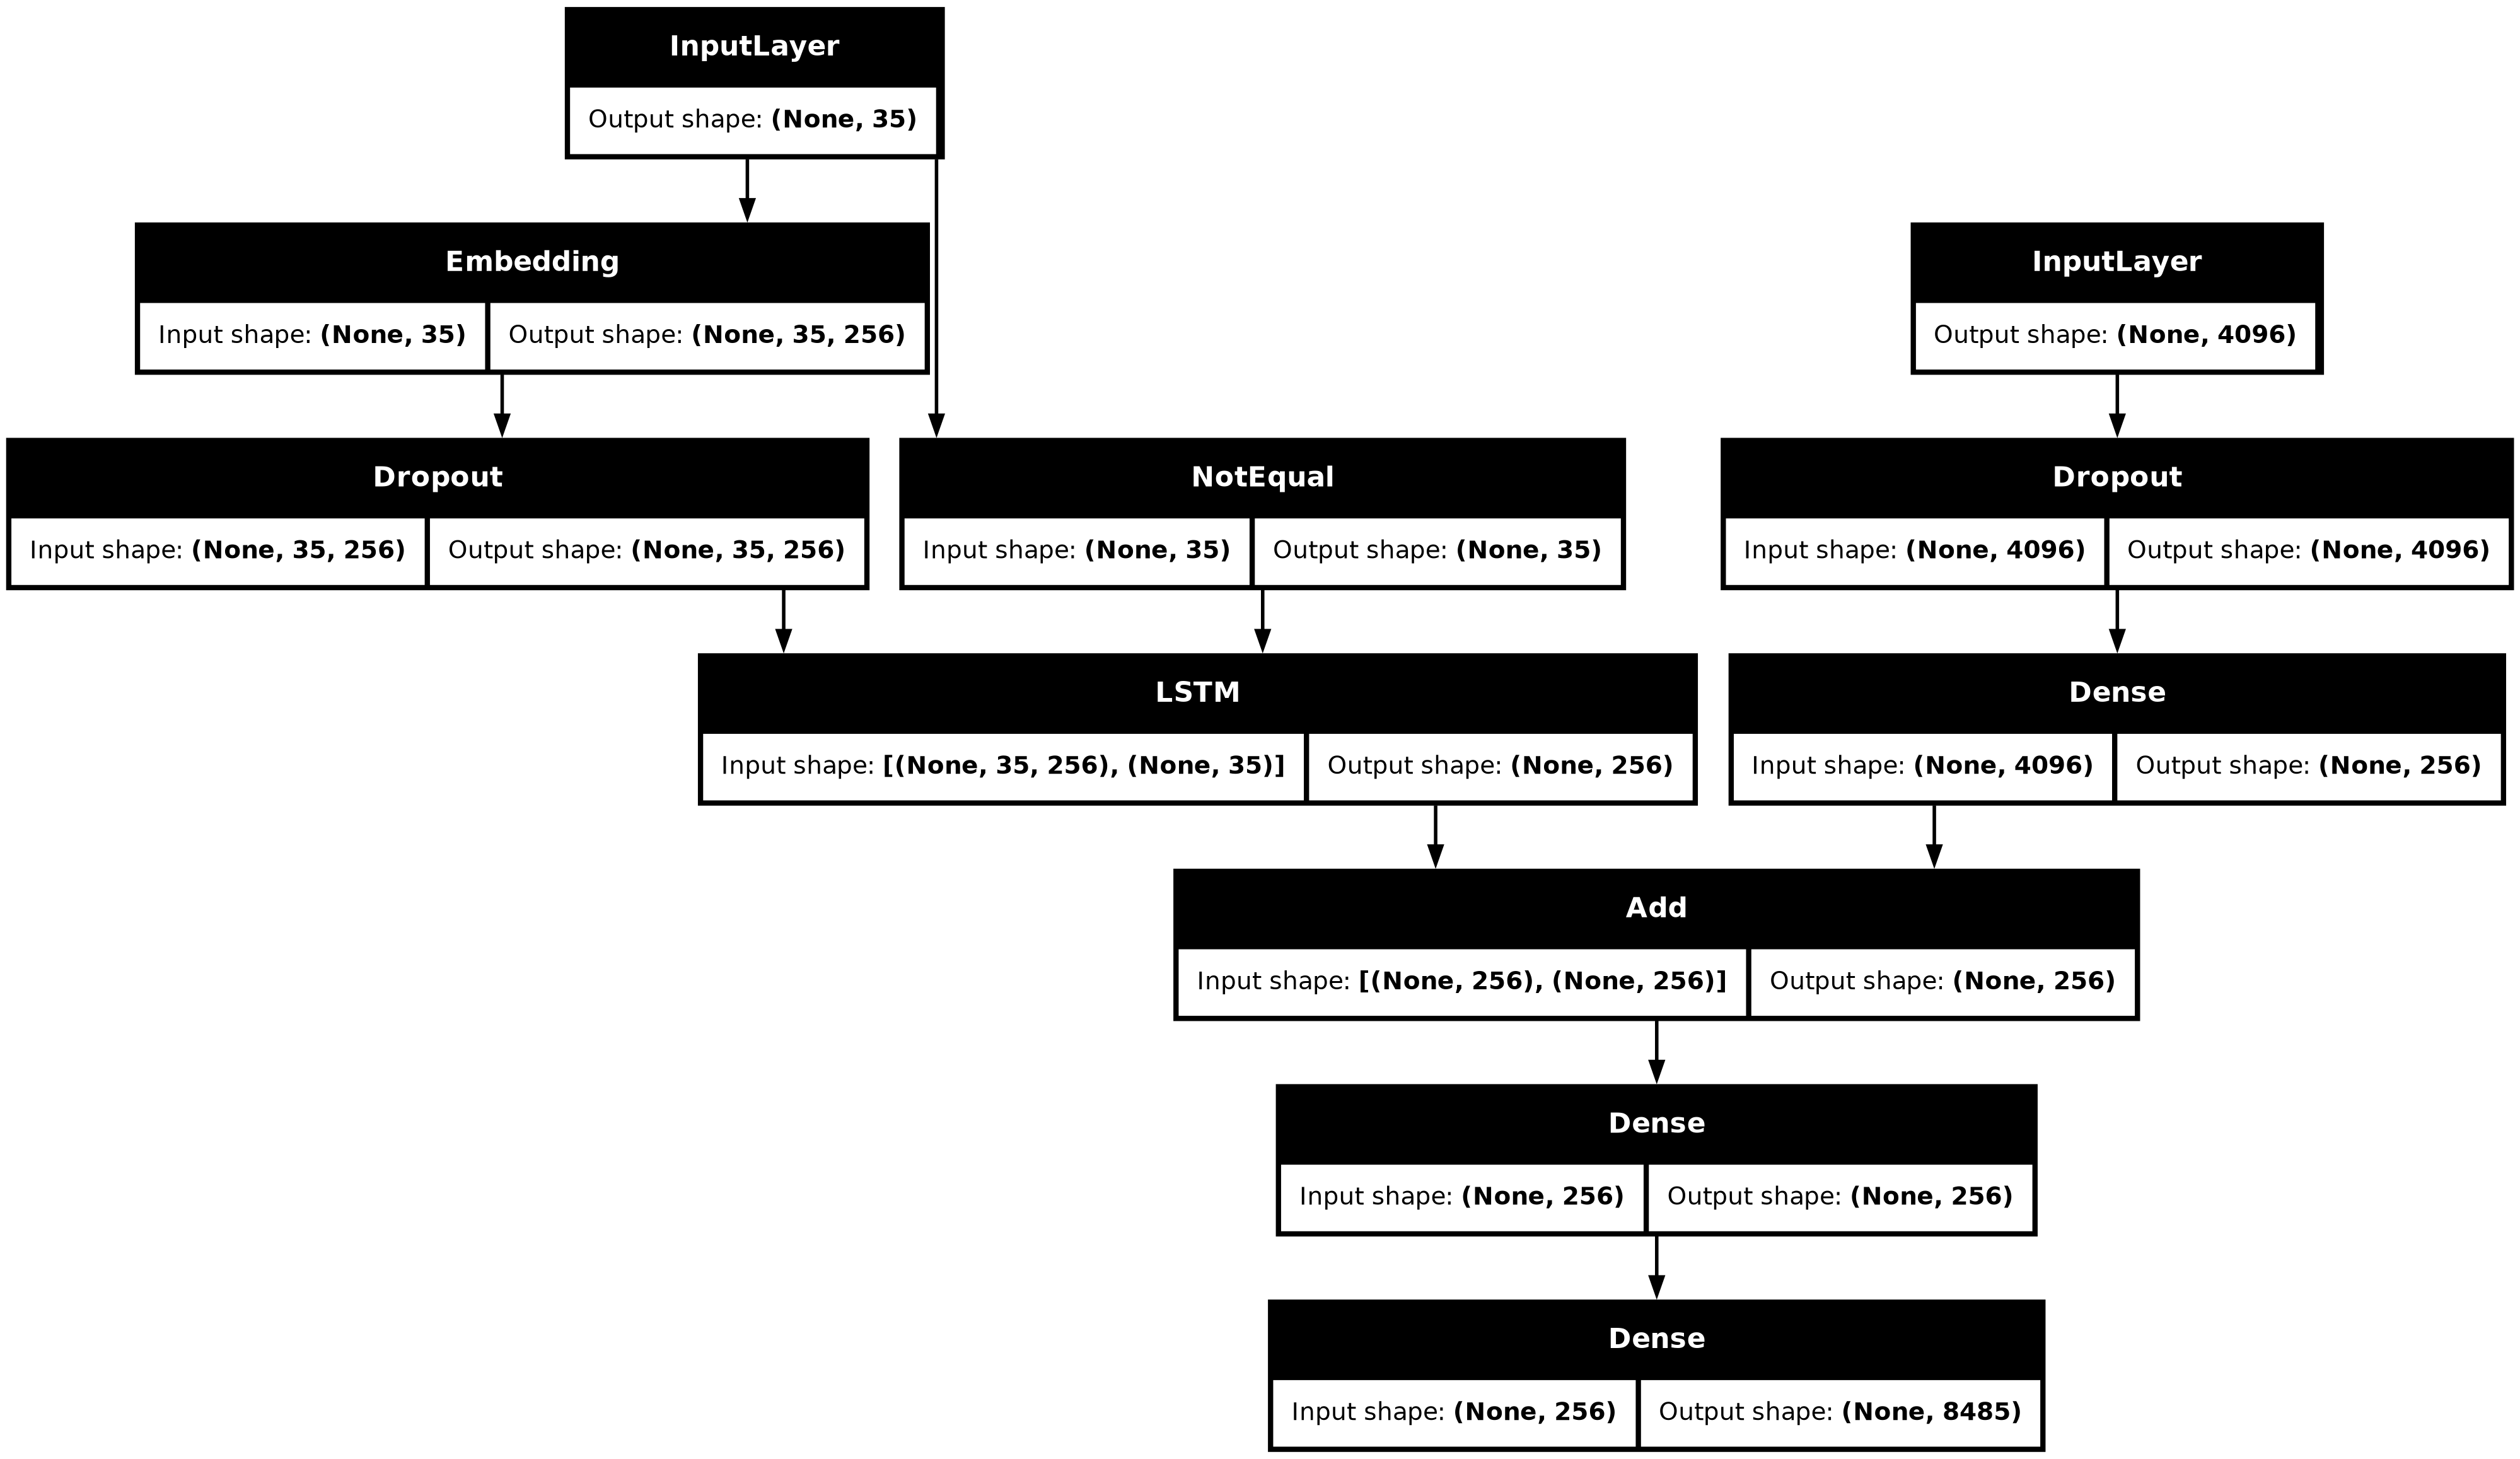

In [22]:

inputs1 = Input(shape=(4096,), name="image")
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

inputs2 = Input(shape=(max_length,), name="text")
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

decoder1 = Add()([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')
plot_model(model, show_shapes=True)


# Train the Model VGG16

In [23]:

train_data, val_data = train_test_split(train, test_size=0.1)

early_stopping = EarlyStopping(
    monitor='val_loss',        
    patience=15,                 
    verbose=1,                 
    restore_best_weights=True  
)

checkpoint = ModelCheckpoint(
    'best_model.keras',        
    monitor='val_loss',        
    save_best_only=True,      
    verbose=1                  
)

epochs = 20
batch_size = 32
steps = len(train_data) // batch_size  

generator = data_generator(train_data, mapping, features, tokenizer, max_length, vocab_size, batch_size)

val_generator = data_generator(val_data, mapping, features, tokenizer, max_length, vocab_size, batch_size)

history = model.fit(
    generator,  
    epochs=epochs,  
    steps_per_epoch=steps,  
    verbose=1, 
    validation_data=val_generator, 
    validation_steps=len(val_data) // batch_size,  
    callbacks=[early_stopping, checkpoint]  
)


Epoch 1/20
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - loss: 5.8829
Epoch 1: val_loss improved from inf to 4.39073, saving model to best_model.keras
204/204 ━━━━━━━━━━━━━━━━━━━━ 57s 260ms/step - loss: 5.8797 - val_loss: 4.3907
Epoch 2/20
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - loss: 4.1229
Epoch 2: val_loss improved from 4.39073 to 3.98451, saving model to best_model.keras
204/204 ━━━━━━━━━━━━━━━━━━━━ 53s 259ms/step - loss: 4.1222 - val_loss: 3.9845
Epoch 3/20
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - loss: 3.6207
Epoch 3: val_loss improved from 3.98451 to 3.87483, saving model to best_model.keras
204/204 ━━━━━━━━━━━━━━━━━━━━ 53s 261ms/step - loss: 3.6203 - val_loss: 3.8748
Epoch 4/20
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step - loss: 3.3316
Epoch 4: val_loss improved from 3.87483 to 3.87375, saving model to best_model.keras
204/204 ━━━━━━━━━━━━━━━━━━━━ 55s 272ms/step - loss: 3.3313 - val_loss: 3.8738
Epoch 5/20
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step - loss: 3.1223
Epoch 5

In [24]:
model.save('VGG16model.keras')


**Traning Loss VGG16**

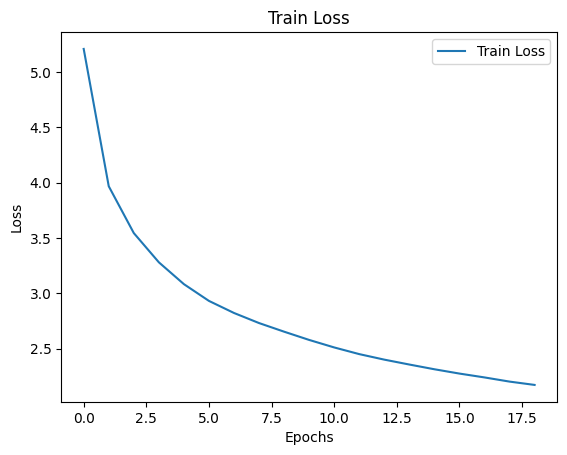

In [25]:

train_loss = history.history['loss']
plt.plot(train_loss, label='Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Train Loss')
plt.show()


# Generate a Caption for an Image VGG16

**Predict Caption**

In [26]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

def predict_caption(model, image, tokenizer, max_length):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], max_length, padding='post')
        yhat = model.predict([image, sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = idx_to_word(yhat, tokenizer)
        if word is None:
            break
        in_text += " " + word
        if word == 'endseq':
            break
    return in_text


# Display Image with Caption VGG16

**Generate Caption**

In [27]:

def generate_caption(image_name):
    image_id = image_name.split('.')[0]
    
    img_path = os.path.join(BASE_DIR, "Images", image_name)  
    image = Image.open(img_path)
    
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    y_pred = y_pred.replace('startseq', '').replace('endseq', '').strip()
        
    print("Generated Caption: ", y_pred)

    plt.imshow(image)
    plt.axis('off')
    plt.show()

    tts = gTTS(y_pred, lang='en')
    audio_path = f"predicted_caption_{image_name.split('.')[0]}.mp3"
    tts.save(audio_path)

    print("Click to play audio:")
    display(Audio(audio_path))
    print("\n\n")


Generated Caption:  three children are playing in fountain


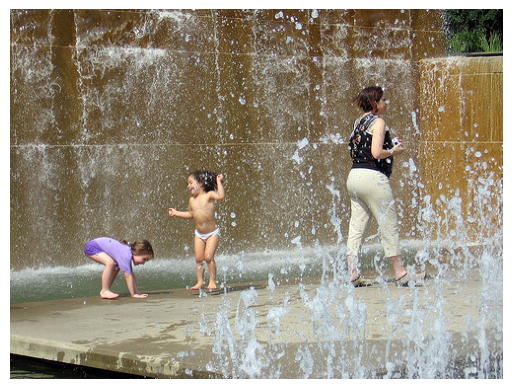

Click to play audio:





Generated Caption:  girl slides down slide


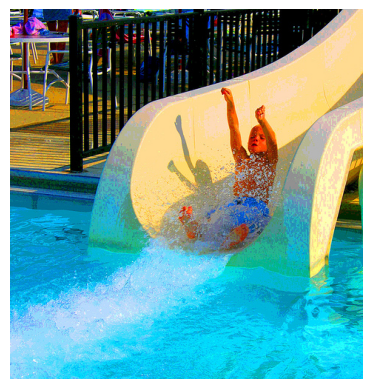

Click to play audio:





Generated Caption:  man is riding bike on dirt hill


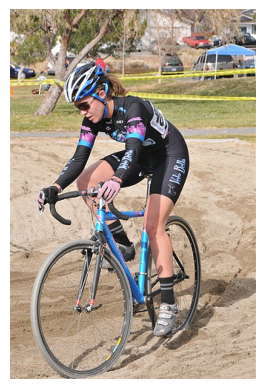

Click to play audio:


In [28]:

    images_path = os.listdir(os.path.join(BASE_DIR, "Images"))
    random_images = np.random.choice(images_path, 3, replace=False)
    
    for image_name in random_images:
        generate_caption(image_name)

# Evaluate the Model VGG16

**BELU for VGG16**

In [29]:
actual, predicted = list(), list()

for key in tqdm(test):
    captions = mapping[key]
    y_pred = predict_caption(model, features[key], tokenizer, max_length)

    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    
    actual.append(actual_captions)
    predicted.append(y_pred)
bleu_1 = corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0))
bleu_2 = corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0))

print("Final BLEU-1: %f" % bleu_1)
print("Final BLEU-2: %f" % bleu_2)


100%|██████████| 810/810 [06:35<00:00,  2.05it/s]


Final BLEU-1: 0.565948
Final BLEU-2: 0.348363


**ROUGE for VGG16**

In [30]:

VGG_rouge_scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2'], use_stemmer=True)
actual, predicted = list(), list()

for key in tqdm(test):
    
    captions = mapping[key]
    y_pred = predict_caption(model, features[key], tokenizer, max_length)
    
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    
    actual.append(actual_captions)
    predicted.append(y_pred)

rouge_1_scores = []
rouge_2_scores = []

for i in range(len(actual)):
    actual_text = ' '.join(actual[i][0])  
    predicted_text = ' '.join(predicted[i])
    
    scores = VGG_rouge_scorer.score(actual_text, predicted_text)
    rouge_1_scores.append(scores['rouge1'].fmeasure)
    rouge_2_scores.append(scores['rouge2'].fmeasure)

avg_rouge_1 = sum(rouge_1_scores) / len(rouge_1_scores)
avg_rouge_2 = sum(rouge_2_scores) / len(rouge_2_scores)

print("Average ROUGE-1: %f" % avg_rouge_1)
print("Average ROUGE-2: %f" % avg_rouge_2)


100%|██████████| 810/810 [06:40<00:00,  2.02it/s]


Average ROUGE-1: 0.375795
Average ROUGE-2: 0.080683


# MobileNet V3

In [31]:
IMAGES_DIR = os.path.join(BASE_DIR, 'Images')
image_filenames = os.listdir(IMAGES_DIR)


# Load MBV3

In [32]:

model = MobileNetV3Large(weights='imagenet', include_top=True)
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)

learning_rate = 0.001
optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()


/opt/conda/lib/python3.10/site-packages/keras/src/applications/mobilenet_v3.py:512: UserWarning: `input_shape` is undefined or non-square, or `rows` is not 224. Weights for input shape (224, 224) will be loaded as the default.
  return MobileNetV3(


22661472/22661472 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, None,      │          0 │ input_layer_1[0]… │
│ (Rescaling)         │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv (Conv2D)       │ (None, None,      │        432 │ rescaling[0][0]   │
│                     │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_bn             │ (None, None,      │         64 │ conv[0][0]        │
│ (BatchNormalizatio… │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, None,      │          0 │ conv_bn[0][0]     │
│ (Activation)        │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, None,      │        144 │ activation[0][0]  │
│ (DepthwiseConv2D)   │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, None,      │         64 │ expanded_conv_de… │
│ (BatchNormalizatio… │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, None,      │          0 │ expanded_conv_de… │
│                     │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, None,      │        256 │ re_lu[0][0]       │
│ (Conv2D)            │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, None,      │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_add   │ (None, None,      │          0 │ activation[0][0], │
│ (Add)               │ None, 16)         │            │ expanded_conv_pr… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_ex… │ (None, None,      │      1,024 │ expanded_conv_ad… │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_ex… │ (None, None,      │        256 │ expanded_conv_1_… │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, None,      │          0 │ expanded_conv_1_… │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_de… │ (None, None,      │          0 │ re_lu_1[0][0]     │
│ (ZeroPadding2D)     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_de… │ (None, None,      │        576 │ expanded_conv_1_… │
│ (DepthwiseConv2D)   │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_de… │ (None, None,      │        256 │ expanded_conv_1_

 Total params: 5,507,432 (21.01 MB)

 Trainable params: 5,483,032 (20.92 MB)

 Non-trainable params: 24,400 (95.31 KB)

# Feature Extraction MBV3

In [33]:
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input 


features2 = {}
directory = os.path.join(BASE_DIR, 'Images') 

valid_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.gif']


for img_name in tqdm(os.listdir(directory)):
    
    file_extension = os.path.splitext(img_name)[1].lower()

    if file_extension in valid_extensions:
        try:
            
            img_path = os.path.join(directory, img_name)
            image = load_img(img_path, target_size=(224, 224))
            image = img_to_array(image)
            image = np.expand_dims(image, axis=0)
            image = preprocess_input(image)
            
            feature2 = model.predict(image, verbose=0)
            image_id = img_name.split('.')[0]
            features2[image_id] = feature2


        except UnidentifiedImageError:
            print(f"Could not identify image file: {img_name}")
        except Exception as e:
            print(f"Error processing {img_name}: {e}")
    else:
        print(f"Skipping non-image file: {img_name}")


100%|██████████| 8091/8091 [07:51<00:00, 17.18it/s]


In [34]:
pickle.dump(features2, open(os.path.join(WORKING_DIR, 'features2.pkl'), 'wb'))


In [35]:
with open(os.path.join(WORKING_DIR, 'features2.pkl'), 'rb') as f:
    features = pickle.load(f)


In [36]:
len(all_captions)


40455

In [37]:
vocab_size

8485

In [38]:
print(f'Train data count: {len(train)}')
print(f'Test data count: {len(test)}')


Train data count: 7281
Test data count: 810


# DATA Genertor MB3

In [39]:
def data_generator2(data_keys, mapping, features2, tokenizer, max_length, vocab_size, batch_size):
    X1, X2, y = list(), list(), list()
    n = 0

    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]

            for caption in captions:
                seq = tokenizer.texts_to_sequences([caption])[0]

                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]

                    in_seq = pad_sequences([in_seq], maxlen=max_length, padding='post')[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

                    X1.append(features2[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)

            if n == batch_size:
                yield {"image": np.array(X1), "text": np.array(X2)}, np.array(y)
                X1, X2, y = list(), list(), list()
                n = 0


# Create Mode MBV3

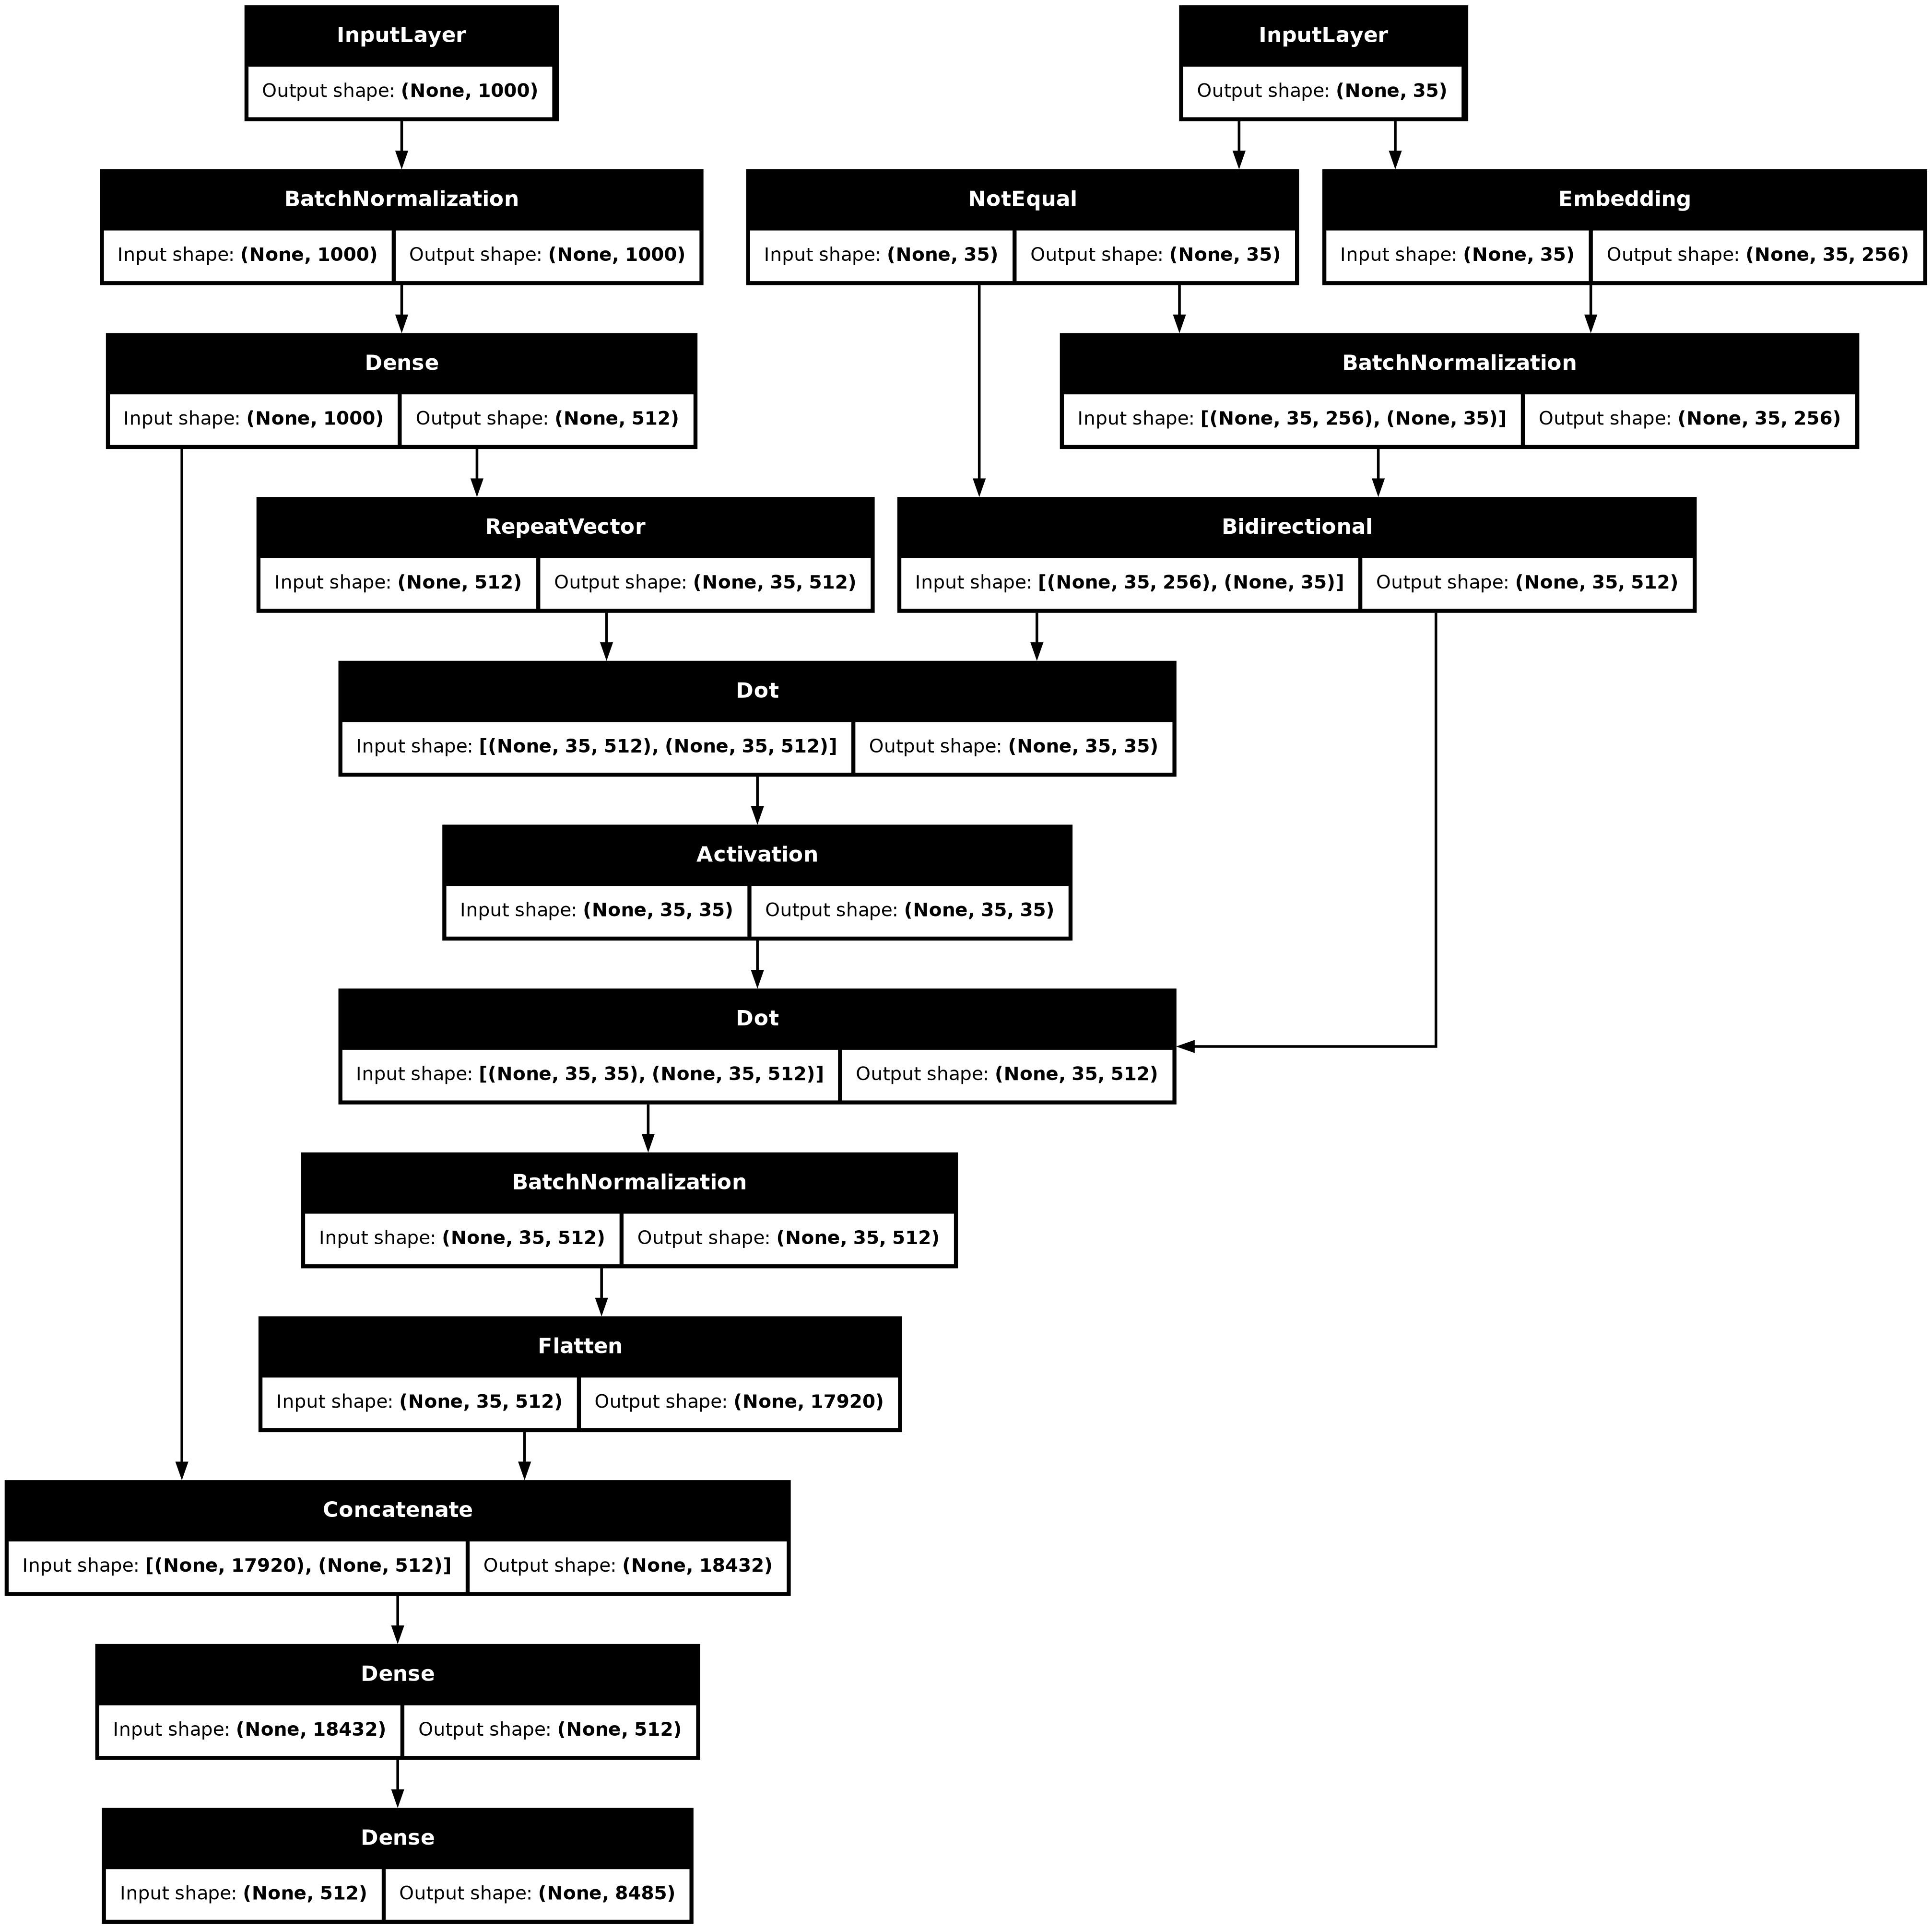

In [40]:
inputs1 = Input(shape=(1000,),name='image')
fe1 = BatchNormalization()(inputs1)
fe2 = Dense(512, activation='relu')(fe1)
fe2_projected = RepeatVector(max_length)(fe2)

inputs2 = Input(shape=(max_length,), name='text')
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = BatchNormalization()(se1)
se3 = Bidirectional(LSTM(256, return_sequences=True))(se2)

attention = Dot(axes=[2, 2])([fe2_projected, se3])
attention = Activation('softmax')(attention)
context_vector = Dot(axes=[1, 1])([attention, se3])
context_vector = BatchNormalization()(context_vector)


context_vector = tf.keras.layers.Flatten()(context_vector)
decoder1 = Concatenate()([context_vector, fe2])
decoder2 = Dense(512, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
optimizer = Adam(learning_rate=5e-4, clipvalue=5.0)
model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=['accuracy'])


plot_model(model, show_shapes=True)


# Model Tranaing MBV3

In [41]:

train_data, val_data = train_test_split(train, test_size=0.1)

early_stopping = EarlyStopping(
    monitor='val_loss',        
    patience=15,                 
    verbose=1,                 
    restore_best_weights=True  
)

checkpoint = ModelCheckpoint(
    'best_model.keras',        
    monitor='val_loss',        
    save_best_only=True,      
    verbose=1                  
)

epochs = 20
batch_size = 32
steps = len(train_data) // batch_size  

generator = data_generator2(train_data, mapping, features2, tokenizer, max_length, vocab_size, batch_size)

val_generator = data_generator2(val_data, mapping, features2, tokenizer, max_length, vocab_size, batch_size)

history = model.fit(
    generator,  
    epochs=epochs,  
    steps_per_epoch=steps,  
    verbose=1, 
    validation_data=val_generator, 
    validation_steps=len(val_data) // batch_size,  
    callbacks=[early_stopping, checkpoint]  
)


Epoch 1/20
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - accuracy: 0.1781 - loss: 5.5174
Epoch 1: val_loss improved from inf to 6.39117, saving model to best_model.keras
204/204 ━━━━━━━━━━━━━━━━━━━━ 59s 266ms/step - accuracy: 0.1783 - loss: 5.5134 - val_accuracy: 0.1188 - val_loss: 6.3912
Epoch 2/20
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.3087 - loss: 3.6338
Epoch 2: val_loss improved from 6.39117 to 5.56522, saving model to best_model.keras
204/204 ━━━━━━━━━━━━━━━━━━━━ 53s 258ms/step - accuracy: 0.3088 - loss: 3.6331 - val_accuracy: 0.1921 - val_loss: 5.5652
Epoch 3/20
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - accuracy: 0.3525 - loss: 3.0840
Epoch 3: val_loss improved from 5.56522 to 3.78271, saving model to best_model.keras
204/204 ━━━━━━━━━━━━━━━━━━━━ 52s 257ms/step - accuracy: 0.3525 - loss: 3.0834 - val_accuracy: 0.3119 - val_loss: 3.7827
Epoch 4/20
204/204 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step - accuracy: 0.3932 - loss: 2.6523
Epoch 4: val_loss improved from 3.782

In [42]:
model.save('MBmodel.keras')


**Traning Loss**

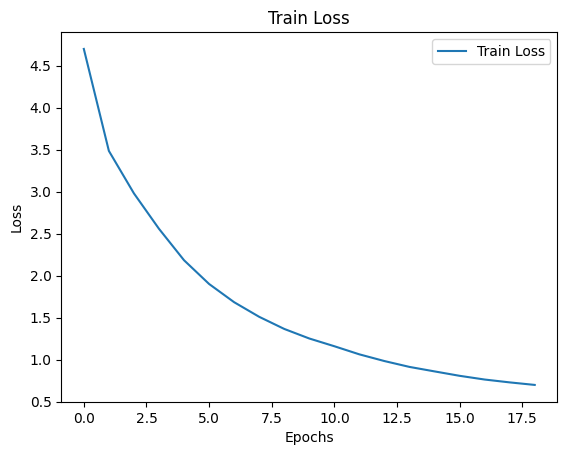

In [43]:
train_loss2 = history.history['loss']

plt.plot(train_loss2, label='Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Train Loss')
plt.show()


# Generate Caption MB3

In [44]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None


def predict_caption(model, image, tokenizer, max_length):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], max_length,padding='post')
        yhat = model.predict([image, sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = idx_to_word(yhat, tokenizer)
        if word is None:
            break
        in_text += " " + word
        if word == 'endseq':
            break

    return in_text


# Display Image with Caption MB3

In [45]:
def generate_caption(image_name):
    image_id = image_name.split('.')[0]

    img_path = os.path.join(BASE_DIR, "Images", image_name)
    image = Image.open(img_path)

    prediction = predict_caption(model, features2[image_id], tokenizer, max_length)
    caption_text = prediction.replace('startseq', '').replace('endseq', '').strip()
    
    
    print("Generated Caption:", caption_text)
    plt.axis('off')
    plt.imshow(image)
    plt.show()


    tts = gTTS(caption_text, lang='en')
    audio_path = "predicted_caption.mp3"
    tts.save(audio_path)

    print("Click to play audio:")
    display(Audio(audio_path))  
    print("\n\n")


Generated Caption: two young children are playing in sandbox


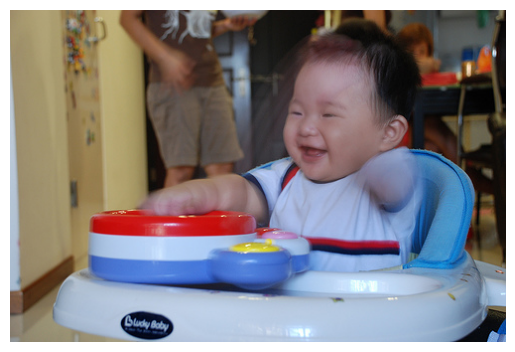

Click to play audio:





Generated Caption: boy in yellow shirt is jumping out of the water


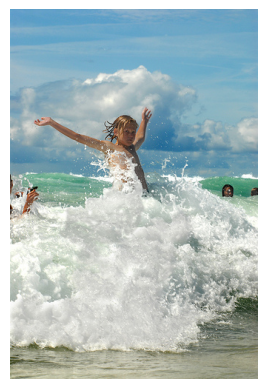

Click to play audio:





Generated Caption: young boy is running on beach


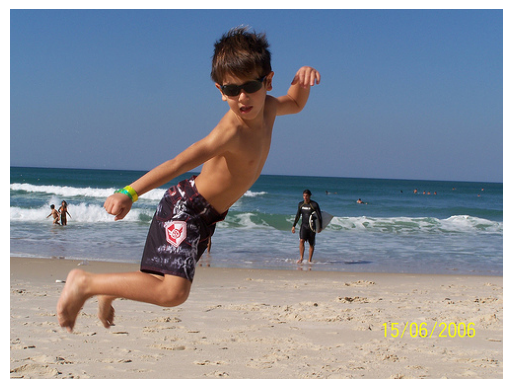

Click to play audio:


In [46]:

images_path = os.listdir(os.path.join(BASE_DIR,'Images'))
image_name_idx = np.random.randint(0,8000,3)

for i in image_name_idx:
    generate_caption(images_path[i])


# Evaluate the Model MB3

**BELU**

In [47]:
actual, predicted = list(), list()

for key in tqdm(test):
    captions = mapping[key]
    y_pred = predict_caption(model, features2[key], tokenizer, max_length)

    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    
    actual.append(actual_captions)
    predicted.append(y_pred)
bleu_1 = corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0))
bleu_2 = corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0))

print("Final BLEU-1: %f" % bleu_1)
print("Final BLEU-2: %f" % bleu_2)


100%|██████████| 810/810 [07:29<00:00,  1.80it/s]


Final BLEU-1: 0.571180
Final BLEU-2: 0.343861


**ROUGE**

In [48]:
mb_rouge_scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2'], use_stemmer=True)

actual, predicted = list(), list()

for key in tqdm(test):
    captions = mapping[key]
    y_pred = predict_caption(model, features2[key], tokenizer, max_length)
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    
    actual.append(actual_captions)
    predicted.append(y_pred)


rouge_1_scores = []
rouge_2_scores = []

for i in range(len(actual)):
    actual_text = ' '.join(actual[i][0])  
    predicted_text = ' '.join(predicted[i])
    
    scores = mb_rouge_scorer.score(actual_text, predicted_text)
    rouge_1_scores.append(scores['rouge1'].fmeasure)
    rouge_2_scores.append(scores['rouge2'].fmeasure)

avg_rouge_1 = sum(rouge_1_scores) / len(rouge_1_scores)
avg_rouge_2 = sum(rouge_2_scores) / len(rouge_2_scores)

print("Average ROUGE-1: %f" % avg_rouge_1)
print("Average ROUGE-2: %f" % avg_rouge_2)


100%|██████████| 810/810 [07:43<00:00,  1.75it/s]


Average ROUGE-1: 0.390363
Average ROUGE-2: 0.095588


**WER**

In [49]:

def calculate_wer(reference, hypothesis):
        
    reference = reference.split()
    hypothesis = hypothesis.split()

    len_ref = len(reference) + 1
    len_hyp = len(hypothesis) + 1
    dp = np.zeros((len_ref, len_hyp))

    
    for i in range(len_ref):
        dp[i][0] = i
    for j in range(len_hyp):
        dp[0][j] = j

    
    for i in range(1, len_ref):
        for j in range(1, len_hyp):
            cost = 0 if reference[i-1] == hypothesis[j-1] else 1
            dp[i][j] = min(dp[i-1][j] + 1,     
                           dp[i][j-1] + 1,     
                           dp[i-1][j-1] + cost)  

    
    return dp[len_ref - 1][len_hyp - 1] / float(len(reference))


def calculate_wer_for_model():
    actual, predicted = list(), list()

    
    for key in tqdm(test):
        captions = mapping[key]  
        y_pred = predict_caption(model, features2[key], tokenizer, max_length)  

        actual_captions = [caption.split() for caption in captions]  
        y_pred = y_pred.split()  
        
        actual.append(actual_captions)
        predicted.append(y_pred)
    
    total_wer = 0

    for i in range(len(actual)):
        reference_caption = ' '.join(actual[i][0])  
        generated_caption = ' '.join(predicted[i])  

        
        total_wer += calculate_wer(reference_caption, generated_caption)
    
    avg_wer = total_wer / len(actual)
    print(f"Average WER: {avg_wer * 100:.2f}%")  
calculate_wer_for_model()


100%|██████████| 810/810 [07:30<00:00,  1.80it/s]

Average WER: 83.22%


# BLIP Model

In [50]:
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")

images_path = '/kaggle/input/flickr8k/Images'
image_files = [f for f in os.listdir(images_path) if f.endswith(('.jpg', '.png', '.jpeg'))]


preprocessor_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/506 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

Generated Caption: a woman in a white hina


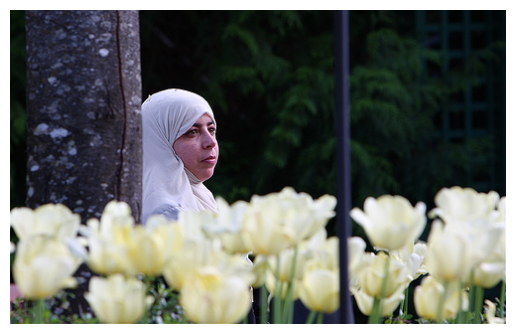

Click to play audio:





Generated Caption: a dog playing with a fr frc


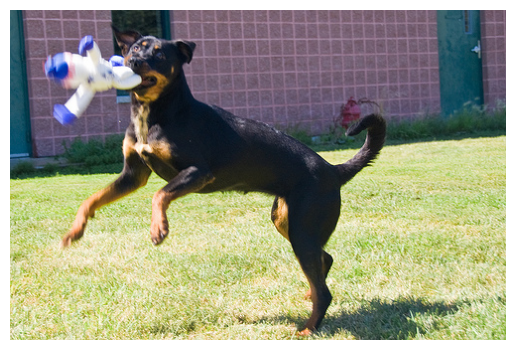

Click to play audio:





Generated Caption: a woman holding a fish


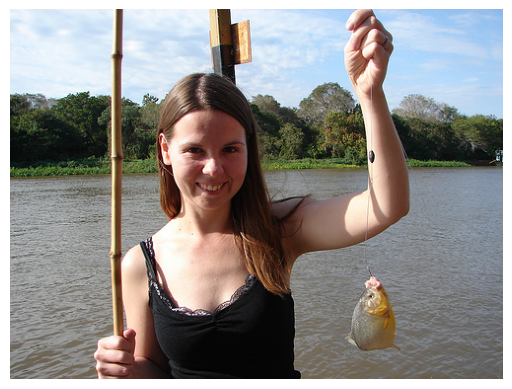

Click to play audio:


In [51]:
random_images = random.sample(image_files, 3)

def generate_caption(image_name):
    image = Image.open(os.path.join(images_path, image_name))
    
    inputs = processor(image, return_tensors="pt")

    output = model.generate(**inputs, max_new_tokens=40) 
    caption_text = processor.decode(output[0], skip_special_tokens=True)
    
    print("Generated Caption:", caption_text)
    
    plt.imshow(image)
    plt.axis('off')
    plt.show()

    tts = gTTS(caption_text, lang='en')
    audio_path = "predicted_caption.mp3"
    tts.save(audio_path)

    print("Click to play audio:")
    display(Audio(audio_path))  
    print("\n\n")

for image_name in random_images:
    generate_caption(image_name)
